In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/lawsdiv`


In [2]:
using DataFrames, DataFramesMeta, GLM
using Statistics, StatsBase
using NFFT
using FHist
using Plots
using Random, Distributions, SpecialFunctions, LsqFit
using DifferentialEquations

In [3]:
include("./script.jl")
using .PlotDistributions

In [4]:
function logistic_growth(S, y0, Δt, n; r=1.0, K=1000 .* ones(S), σ=1.0)
    # Logistic ODE (drift)
    function logistic!(du, u, p, t)
        r, K, σ = p
        du .= r .* u .* (1 .- u ./ K)
    end

    # Diffusion term (multiplicative noise)
    function diffusion!(du, u, p, t)
        σ = p[3]
        du .= σ .* u
    end

    # Callback to clip negative values to zero
    function condition(u, t, integrator)
        any(u .< 0)  # trigger when any component is negative
    end

    function affect!(integrator)
        integrator.u .= max.(integrator.u, 0.0)
    end

    cb = DiscreteCallback(condition, affect!)

    # Problem definition
    tspan = (0.0, n * Δt)
    p = (r, K, σ)
    prob = SDEProblem(logistic!, diffusion!, y0, tspan, p)

    # Solve with callback
    sol = solve(prob, SRIW1(), callback=cb, saveat=Δt)

    # Return solution as matrix (rows = time steps, columns = variables)
    return reduce(hcat, sol.u)'
end;

# Temporal Distributions

### AFD

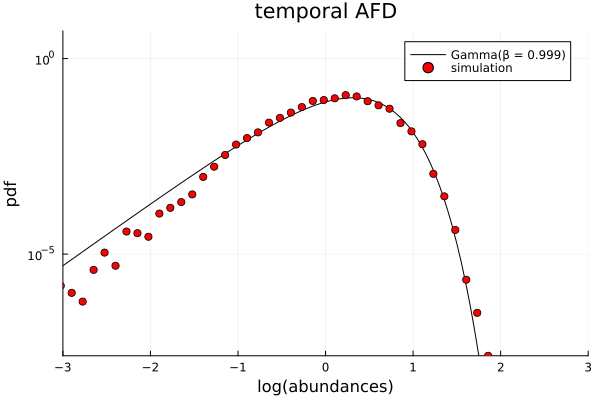

In [5]:
Random.seed!(1234)

# Set parameters
N_species = 1
Δt = 0.1
n = 10000
skip = 1

# Set conditions for temporal analysis
K = 1000.0 .* ones(N_species)
# Pass y0 = K to the model so it is already at staedy state

# Solve model
y = logistic_growth(N_species, K, Δt, n; r=1.0, K=K, σ=1.0)
y = y[1:skip:end, :] # Skip entries to simulate large sample sample gathering windows

# Extract data for temporal analysis
t_data = y[:,1]
t_data = t_data[t_data .> 0.0]

# Compute AFD
t_afd = PlotDistributions.make_AFD(t_data; Δb=0.2, plot_fig=true, save_plot=true, plot_name="./Images/SLM_AFD_t.png", plot_title="temporal AFD")
display(t_afd["fig"])

### Taylor's Law

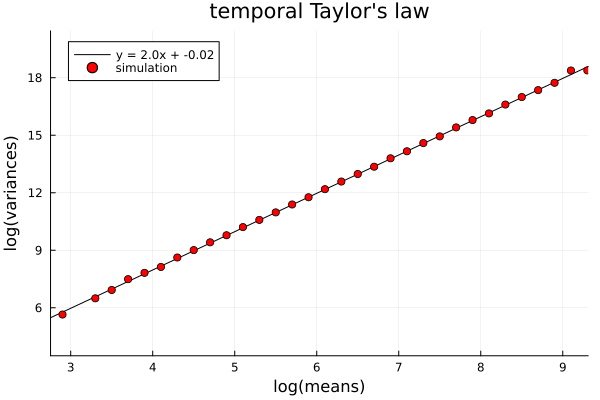

In [6]:
Random.seed!(1234)

# Set parameters
N_species = 2000
Δt = 0.1
n = 10000
skip = 1

# Set conditions for temporal analysis
K = 1000.0 .* rand(LogNormal(), N_species)
# Pass y0 = K to the model so it is already at staedy state

# Solve model
y = logistic_growth(N_species, K, Δt, n; r=1.0, K=K, σ=1.0)
y = y[1:skip:end, :] # Skip entries to simulate large sample sample gathering windows

# Compute Taylor
t_taylor = PlotDistributions.make_Taylor(y; Δb=0.2, plot_fig=true, save_plot=false, plot_name="./Images/SLM_Taylor_t.png", plot_title="temporal Taylor's law")
display(t_taylor["fig"])

### MAD

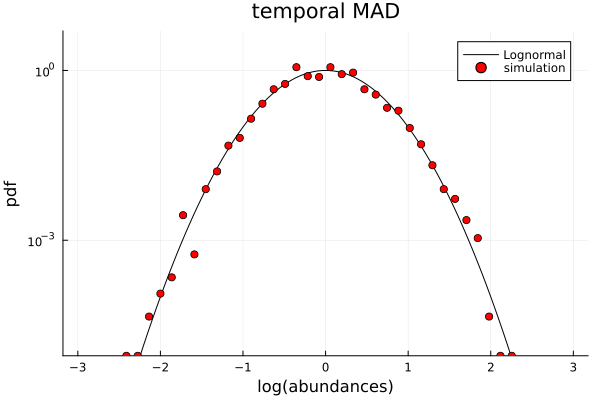

In [7]:
# Compute MAD
t_MAD = PlotDistributions.make_MAD(y; Δb=0.2, plot_fig=true, save_plot=false, plot_name="./Images/SLM_MAD_t.png", plot_title="temporal MAD")
display(t_MAD["fig"])

# Ensemble Distributions

### AFD

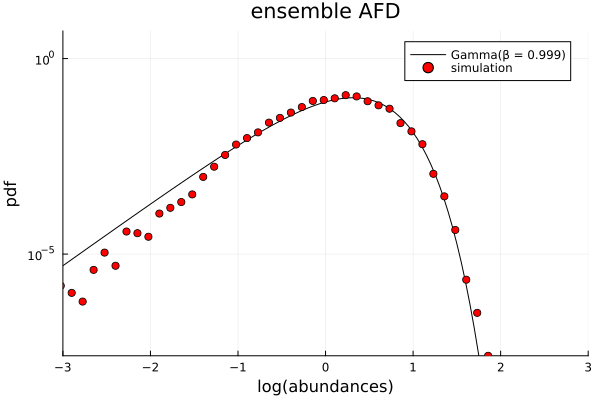

In [8]:
Random.seed!(1234)

# Set parameters
N_species = 5000
Δt = 0.1
n = 10000
skip = 1

# Set conditions for temporal analysis
K = 1000.0 .* ones(N_species)
# Pass y0 = K to the model so it is already at staedy state

# Solve model
y = logistic_growth(N_species, K, Δt, n; r=1.0, K=K, σ=1.0)
y = y[1:skip:end, :] # Skip entries to simulate large sample sample gathering windows

# Extract data for temporal analysis
e_data = y[end,:]
e_data = t_data[t_data .> 0.0]

# Compute AFD
e_afd = PlotDistributions.make_AFD(e_data; Δb=0.2, plot_fig=true, save_plot=true, plot_name="./Images/SLM_AFD_e.png", plot_title="ensemble AFD")
display(e_afd["fig"])

### Taylor's Law

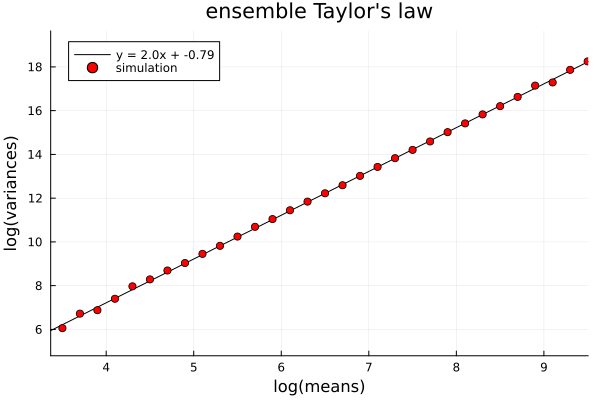

In [9]:
Random.seed!(1234)

# Set parameters
N_species = 1000
n_ens = 200
Δt = 0.1
n = 1000
skip = 1

# Set conditions for temporal analysis
K = 1000.0 .* rand(LogNormal(), N_species)
# Pass y0 = K to the model so it is already at steady state

# Solve model
e_data = zeros(1,N_species)
for _ in 1:n_ens
    y = logistic_growth(N_species, K, Δt, n; r=1.0, K=K, σ=0.8)
    y = y[1:skip:end, :] # Skip entries to simulate large sample sample gathering windows
    e_data = vcat(e_data, permutedims(y[end, :]))
end

e_data = e_data[2:end,:]

# Compute Taylor
e_taylor = PlotDistributions.make_Taylor(e_data; Δb=0.2, plot_fig=true, save_plot=false, plot_name="./Images/SLM_Taylor_e.png", plot_title="ensemble Taylor's law")
display(e_taylor["fig"])

### MAD

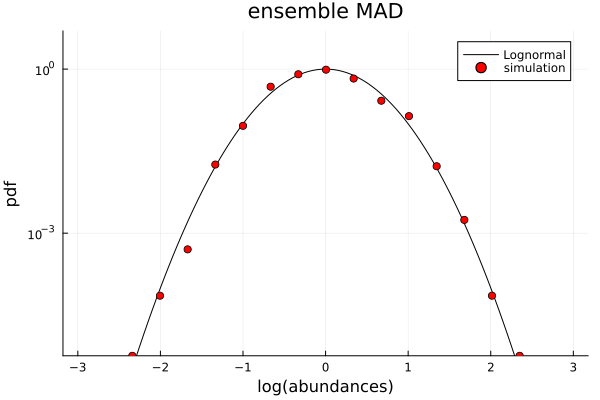

In [10]:
# Compute MAD
e_MAD = PlotDistributions.make_MAD(e_data; Δb=0.5, plot_fig=true, save_plot=false, plot_name="./Images/LSM_MAD_e.png", plot_title="ensemble MAD")
display(e_MAD["fig"])

# Power Spectrum Density analysis

In [14]:
Random.seed!(1234)

# Set parameters
N_species = 100
Δt = 0.1
n = 10000
skip = 1

# Set conditions for temporal analysis
K = 1000.0 .* ones(N_species)
# Pass y0 = K to the model so it is already at staedy state

# Solve model
y = logistic_growth(N_species, K, Δt, n; r=1.0, K=K, σ=1.0)
y = y[1:skip:end, :]; # Skip entries to simulate large sample sample gathering windows

In [23]:
# Set paramas and variables to perform NFFT
times =[t for t in 1:skip*Δt:n]
N = length(times)
fs = 1 / (skip*Δt)
Nf = fs / 2 # Since sample rate is 1 day
frequencies = (-Int(floor(N/2)):Int(floor(N/2) - 1)) * fs / N # Frequency domain

mean_S = zeros(n) # Initialize array
otu_count = 0 # Needed for normalization
t_normalized = (times ./ N) .- 0.5

for i in 1:N_species
    x = y[:,i]
    x .-= mean(x)

    otu_count += 1
    p_nfft = NFFT.plan_nfft(t_normalized, N, reltol=1e-9)
    fhat = adjoint(p_nfft) * x

    S = abs2.(fhat) .* (skip * Δt / N)
    mean_S .+= S
end

# Take only positive frequencies
positive = frequencies .> 0
frequencies = frequencies[positive]
mean_S = mean_S[positive] ./ otu_count;

LoadError: DimensionMismatch: Data is not consistent with NFFTPlan

In [21]:
t_normalized

99991-element Vector{Float64}:
 -0.4999
 -0.49989
 -0.49988
 -0.49987
 -0.49986
 -0.49985
 -0.49984
 -0.49983
 -0.49982
 -0.49981
 -0.4998
 -0.49979
 -0.49978
  ⋮
  0.49988999999999995
  0.4999
  0.4999100000000001
  0.49992000000000003
  0.4999299999999999
  0.49993999999999994
  0.49995
  0.49996000000000007
  0.49997
  0.49998
  0.49998999999999993
  0.5

In [13]:
# # Take logs
log_f = log10.(frequencies)
log_S = log10.(mean_S)

# Filter frequencies to avoid bias at too low and too high frequencies
# Essentially the fact the we have linear frequency binning but we compute the slope in log-log space creates problems
# at very low freqs because there are less points and at very high freqs because there are too many points. Moreover these
# methods are exact only in the infinite time case so we need to consider border effects.
mask = (log_f .> -1.3) .& (log_f .< -0.5)
log_f = log_f[mask]
log_S = log_S[mask]

# Put into a DataFrame and fit linear model: log_S ~ log_k
plot_df = DataFrame(log_f=log_f, log_S=log_S)
model = lm(@formula(log_S ~ log_f), plot_df)

# Extract the slope and intercept
coeffs = coef(model)
slope = coeffs[2]
intercept = coeffs[1]

println("Estimated slope: ", slope)
println("Intercept: ", intercept)

# Plot results
plot(log_f, log_S, label=:none, xlabel="log₁₀(frequency)", ylabel="log₁₀(power)", legend=:bottomleft,
    title="Mean PWD of most abundant species")
plot!(log_f, predict(model), label="Fit: slope = $(round(slope, digits=2))", lw=2)

LoadError: DomainError with -5.0:
log10 was called with a negative real argument but will only return a complex result if called with a complex argument. Try log10(Complex(x)).
DomainError detected in the user `f` function. This occurs when the domain of a function is violated.
For example, `log(-1.0)` is undefined because `log` of a real number is defined to only output real
numbers, but `log` of a negative number is complex valued and therefore Julia throws a DomainError
by default. Cases to be aware of include:

* `log(x)`, `sqrt(x)`, `cbrt(x)`, etc. where `x<0`
* `x^y` for `x<0` floating point `y` (example: `(-1.0)^(1/2) == im`)

Within the context of SciML, this error can occur within the solver process even if the domain constraint
would not be violated in the solution due to adaptivity. For example, an ODE solver or optimization
routine may check a step at `new_u` which violates the domain constraint, and if violated reject the
step and use a smaller `dt`. However, the throwing of this error will have halted the solving process.

Thus the recommended fix is to replace this function with the equivalent ones from NaNMath.jl
(https://github.com/JuliaMath/NaNMath.jl) which returns a NaN instead of an error. The solver will then
effectively use the NaN within the error control routines to reject the out of bounds step. Additionally,
one could perform a domain transformation on the variables so that such an issue does not occur in the
definition of `f`.

For more information, check out the following FAQ page:
https://docs.sciml.ai/Optimization/stable/API/FAQ/#The-Solver-Seems-to-Violate-Constraints-During-the-Optimization,-Causing-DomainErrors,-What-Can-I-Do-About-That?
